# Martin Jamouss



## Part 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
data = pd.read_csv('hw2_data.csv')
data.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)

In [3]:
data.head()

,I_US,I_EU,Inf_US,Inf_EU,Euro
Date,,,,,
2003-12-01,1.11,2.1590,0.019284,0.021933,1.196501
2004-01-01,1.10,2.1463,0.020352,0.020207,1.258194
2004-02-01,1.06,2.0895,0.020263,0.018343,1.246805
2004-03-01,1.05,2.0706,0.016885,0.016654,1.244803
2004-04-01,1.05,2.0288,0.017401,0.017175,1.236507


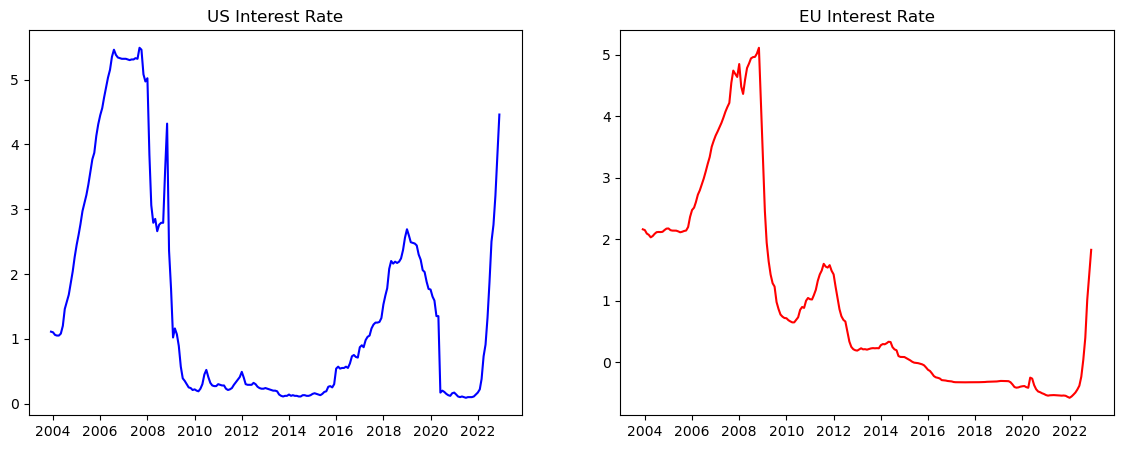

In [4]:
fig = plt.figure(figsize=(14,5))

# Create the first subplot
plt.subplot(1, 2, 1)
plt.plot(data.I_US, 'b')
plt.title("US Interest Rate")

# Create the second subplot
plt.subplot(1, 2, 2)
plt.plot(data.I_EU, 'r')
plt.title("EU Interest Rate")

# Show the plots
plt.show()

## #a

In [5]:
data['I_diff']=data['I_US']-data['I_EU']

## #b

In [6]:
k = 0.4
# This implements the kalman filter
data["Filter"] = data.I_diff.ewm(alpha = k, adjust = False).mean()

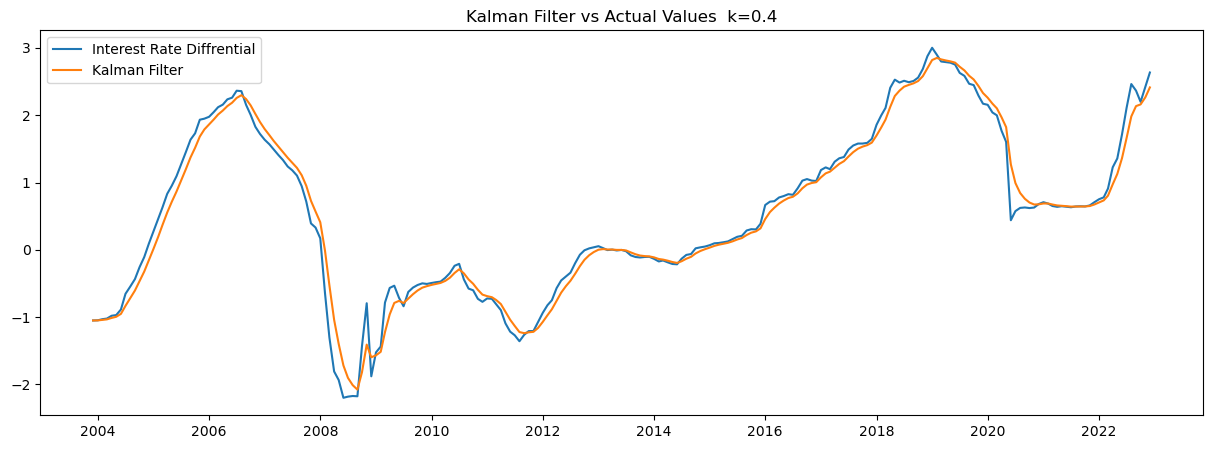

In [7]:
plt.figure(figsize = (15, 5))
plt.plot(data['I_diff'],label = 'Interest Rate Diffrential')
plt.plot(data['Filter'], label = 'Kalman Filter')
plt.title("Kalman Filter vs Actual Values " + " k=" + str(k))
plt.legend()
plt.show()

## #c


In [8]:
w = 10
# Compute the filter error
data["Filter Error"] = data.I_diff - data["Filter"]

# Compute the rolling standard deviation
data["std"] = data["Filter Error"].rolling(w).std()

In [9]:
z = 1.645
# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
data["Upper"] = data["Filter"] + z*data["std"]
data["Lower"] = data["Filter"] - z*data["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
data["test"] = np.where(data["Filter Error"].abs()>z*data["std"], -1, 0)\
    *np.sign(data["Filter Error"])

In [10]:
data.tail()

,I_US,I_EU,Inf_US,Inf_EU,Euro,I_diff,Filter,Filter Error,std,Upper,Lower,test
Date,,,,,,,,,,,,
2022-08-01,2.50,0.0366,0.084821,0.088662,1.020825,2.4634,1.982185,0.481215,0.178875,2.276434,1.687936,-1.0
2022-09-01,2.76,0.3947,0.082492,0.091406,1.003905,2.3653,2.135431,0.229869,0.165722,2.408044,1.862818,0.0
2022-10-01,3.21,1.0109,0.082224,0.099272,0.982956,2.1991,2.160899,0.038201,0.165154,2.432577,1.889220,0.0
2022-11-01,3.85,1.4277,0.077631,0.106206,0.988631,2.4223,2.265459,0.156841,0.155530,2.521306,2.009613,0.0
2022-12-01,4.46,1.8252,0.071179,0.100546,1.042535,2.6348,2.413195,0.221605,0.141047,2.645218,2.181173,0.0


## Part 2

## #a

In [11]:
# Create a dataframe at a daily frequency with start and end 
# dates that cover the observation period
drange = pd.date_range(start =data.index[0], end = "01/01/2023")
daily  = pd.DataFrame(index = drange)

# Integrate the monthly data into the daily data
daily["test"] = data["test"]

daily["Upper"] = data["Upper"]
daily["Lower"] = data["Lower"]
daily["Filter"] = data["Filter"]
daily["I_diff"] = data["I_diff"]

# Fill NA values with the last available value
daily["Upper"] = daily["Upper"].ffill()
daily["Lower"] = daily["Lower"].ffill()
daily["Filter"] = daily["Filter"].ffill()
daily["I_diff"] = daily["I_diff"].ffill()

# fill the remaining NA values with 0's
# also populates the test column
daily = daily.fillna(0)

In [12]:
# We let the holding period (i) be 41 days
i = 41

# create a new column that we will populate with our daily position
daily.loc[:, str(i)+"_signal"] = 0

# loop through each day in the dataset
for j in daily.index:
    # If our monthly signal is not 0
    if daily.loc[j, "test"] != 0:
        # Make the next i days equal to the monthly signal
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "test"]
    
# Below is the holding period I use for the CI strategy
i = 171
daily.loc[:, str(i)+"_signal"] = 0
for j in daily.index:
    if daily.loc[j, "test"] != 0:
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "test"]

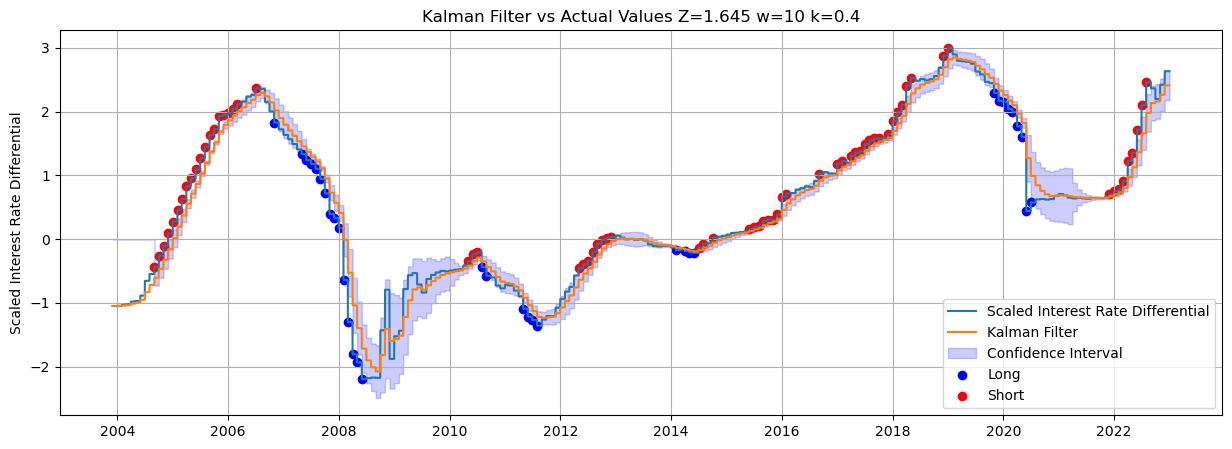

In [13]:
data2 = daily.dropna()
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Scaled Interest Rate Differential")

# Plot the actual series and the filter
ax.plot(data2["I_diff"])
ax.plot(data2["Filter"])

# This code block is used to add confidence intervals when z > 0
ax.fill_between(data2.index, data2.Lower, data2.Upper, color='b', alpha=.2)

# add scatterplots using boolean indexing
# We change the colors and shapes based on the conditions
ax.scatter(data2[data2.test == 1].index, data2[data2.test == 1]["I_diff"], color = "blue")
ax.scatter(data2[data2.test == -1].index, data2[data2.test == -1]["I_diff"], color = "red")
ax.legend(["Scaled Interest Rate Differential", "Kalman Filter", 'Confidence Interval', 'Long', 'Short'])

# this code can let us zoom in on certain time periods
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

We take long positions when the interest rate differential falls below the filter minus some number of standard deviations and short positions when the interest rate differential rises above the filter plus some standard deviations.

In [14]:
# below we add the euro data to the daily df
drange = pd.date_range(start =data.index[0], end = "01/01/2023")
exdf = pd.DataFrame(index = drange)

exdf["EURUSD"] = data['Euro']
exdf["EURUSD"] = exdf["EURUSD"].ffill()

daily["EURUSD"] = exdf["EURUSD"]
daily["Returns"] = np.log(daily["EURUSD"]).diff()

In [15]:
# calculate the cumulative returns for the current strategy
i = 41
daily[str(i)+"_returns"] = np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1
# calculate whether each signal was a success by finding the difference between the returns
# at the switching points. If the difference is positive, that means the signal made money
s = 41
daily[str(s)+"_success"] = ((daily[daily.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

In [16]:
i = 171
daily[str(i)+"_returns"] = np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1
s = 171
daily[str(s)+"_success"] = ((daily[daily.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

## #b

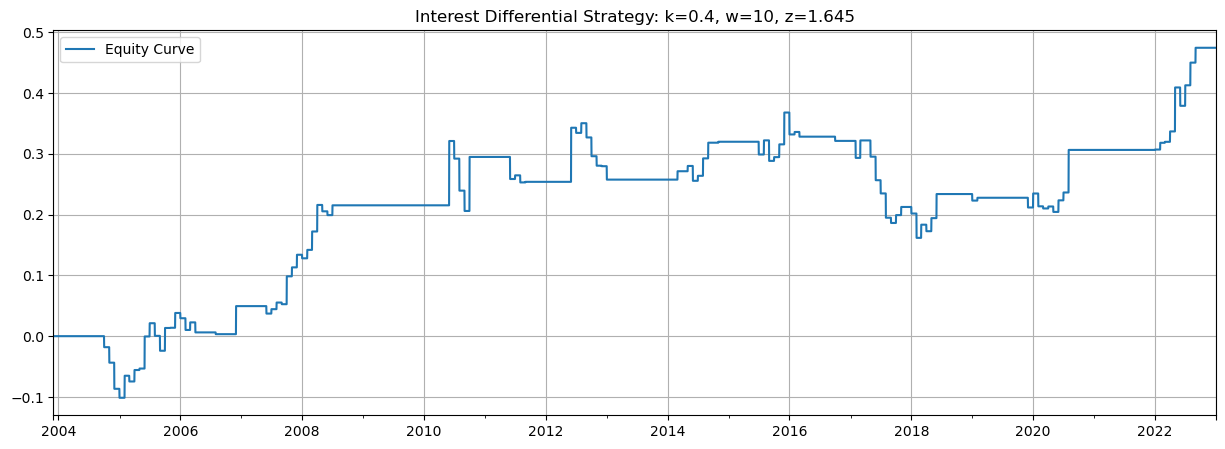

In [17]:
plt.figure(figsize = (15, 5))
d2 = daily[daily.index.year >= 2020]
(daily["41_returns"].dropna()).plot()

plt.title("Interest Differential Strategy:"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))
plt.legend(["Equity Curve"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

## #c
### Binomial test

In [18]:
df = daily[daily.test != 0][["41_signal", "EURUSD"]].copy()
df['D'] = df["41_signal"]

In [19]:
df = df[:-2].copy()
df['s_current'] = daily[daily.index.isin(df.index)]["EURUSD"].values
df['s_future'] = daily[daily.index.isin(df.index+datetime.timedelta(41))]["EURUSD"].values


# Get the realized exchange rate
df['R'] = np.where(df['s_future'] >= df['s_current'], 1, -1)

In [20]:
## Sample Covariance
df['W'] = (df['D']-np.mean(df['D']))*(df['R']-np.mean(df['R']))
T_B = np.mean(df['W'])

In [21]:
## Newey-West LRV estimator
dy = df['W'] - np.mean(df['W'])
gamma_0 = sum((dy)**2)/len(df)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [22]:
## Test-statistic
from scipy.stats import norm

statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  1.1110273972330778 , 5 % critical value :  1.64


We fail to reject the null.

### Weighted directional test

In [23]:
# Weighted Mean
df['W_2'] = df['D']*(df['s_future']-df['s_current'])
T_WB = np.mean(df['W_2'])

In [24]:
## Newey-West LRV estimator
dy_2 = df['W_2'] - np.mean(df['W_2'])
gamma_0 = sum((dy_2)**2)/len(df)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(df)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

In [25]:
## Test-statistic
statistic_2 = T_WB/np.sqrt(LRV_2/len(df))
print('Test statistic : ', statistic_2, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  1.5112392885943242 , 5 % critical value :  1.64


We fail to reject the null.

## #d

How does changing the values of your parameters (k, z, w, T, etc) in question 1 change your results?

When the Kalman gain is closer to 1, the Kalman filter and the interest rate differential almost overlap completely, rendering observations worthless and barely showing any long or short positions. On the other hand, when the Kalman gain is closer to 0, long-term fluctuations are accounted for while short-term fluctuations are not considered.   
In addition using Kalman filter closer to 0, exhibits a downward sloping equity curve suggesting that the investments in the portfolio have underperformed relative to market expectations, while using kalman filter closer to 1, exhibits a positive sloping equity curve.  
With some combination of parameters, we might be able reject the nulll hypothesis of the weighted directional test.



# Part 3
## #a

In [26]:
F = 1000
C = 50
rf = 0.01
T = 10
price = 984.94

In [27]:
# Calculating the Yield to Maturity:
denom = (F + price) / 2
num = C + ((F - price) / T)
YTM = num / denom
print('The Yield to Maturity of this Bond is:', str(round (YTM * 100, 2)) + '%')

The Yield to Maturity of this Bond is: 5.19%


## #b

The expected value of 𝐹𝑡+1 is 𝐸𝑡 (𝐹𝑡+1) = 𝑢 * 𝐹 + (1 − 𝑢) * 0 = 𝑢 * 𝐹 = 0.8 * 1000 = 800  
The bond price is p𝑡 = (50 + 800)/(1 + 0.01) = 841.6

In [28]:
# Initial Variables
mu = 0.2 # 20% probability of defaulting
F = 1000
# Calculating EIF t+11:
expected_F = (1 - mu) * F
# Pricing the Bond: P_t = (C_t+1 + E[F_t+1]) / (1 + rf)
price_t = (C + expected_F) / (1 + rf)
print ('The price of this bond today is: $' + str(round (price_t, 2)))

The price of this bond today is: $841.58


# Part 4
## #a

In [29]:
def bond_duration(c,r,t,FV):
    #c = coupon rate
    #r = interest rate
    #t = number of years
    #FV = face value
    price = 0
    for i in range(t):
        CF = (c*FV) / ((1+r)**(i+1))
        price += CF
    price = price + FV /(1 + r)**(t)

    weights = []
    for i in range(t-1):
        CF = (c*FV)/((1 + r)** (i+1))
        w_t = CF/price 
        weights.append(w_t)

    CF = (c*FV+FV)/((1 +r)**(t))
    w_t = CF/price
    weights.append(w_t)

    period = list (range (1, t+1))
    duration = period @ np.array (weights).T
    return round(duration,2)

In [30]:
print('A 10-year, 15% coupon bond with an interest rate of 10% has a bond duration of'\
    ,bond_duration(0.15, 0.10, 10, 100))

A 10-year, 15% coupon bond with an interest rate of 10% has a bond duration of 6.28


In [31]:
print('A 7-year, 3% coupon bond with an interest rate of 3% has a bond duration of'\
    ,bond_duration(0.03, 0.03, 7, 100))

A 7-year, 3% coupon bond with an interest rate of 3% has a bond duration of 6.42


Interpretability: Bond duration measures the sensitivity of a bonds price to changes in the market interests rates. Thus, a 7-year, 3% coupon bond with an interest rate of 3% is more susceptible to fluctuations to changes in the interest rates.

## #b

For every 1% increase in interest rates, bond price will decrease by the bonds' duration. Since a 7-year with a 3% coupon bond and an interest rate of 3% has a higher duration than a 10-year with a 15% coupon bond and an interest rate of 10%, it is expected to have a greater change (decrease) in price.

## #c

In [32]:
print('Duration of Portfolio =',(0.3*(bond_duration(0.03, 0.03, 7, 100)) + 0.7*(bond_duration(0.15, 0.10, 10, 100))))

Duration of Portfolio = 6.322


# Part 5

## #a

The two monetary policy decisions made by the European Central Bank's (ECB) Governing Council in December 2022 and February 2023 are focused on increasing the three key ECB interest rates and generally taking same procedures to lower inflation. In December 2022, the interet rates increased by 50 basis points to 2.50%, 2.75% and 2.00% respectively while the interet rates increased by 25 basis points to 3.00%, 3.25% and 2.50% respectively in February 2023.     

The Federal Open Market Committee (FOMC) made two monetary policy decisions in December 2022 and February 2023, with a focus on gradually increasing the interest rate and taking measures to lower inflation. In December 2022, the federal funds rate increased by 25 basis points to 4.25% to 4.5% while the interet rates increased by 25 basis points to 4.5% to 4.75%  in February 2023.

## #b

The conflict between Russia and Ukraine came as a surprise to the global economy. The ongoing hostilities have had far-reaching economic impacts, not only for the countries directly involved, but also for the wider global community. as stated by th FOMC, the war and its associated events are driving up inflation and negatively affecting global economic growth.

## #c

The depreciation of the Euro can be attributed to several factors, one of which being the conflict between Russia and Ukraine. Europe has been affected more by the conflict than the United States due to its proximity, energy dependence, and strong trade ties with Russia and Ukraine. For instance, Europe's heavy dependence on Russia for energy needs has led to disruptions in the flow of Russian natural gas to Europe, and the disruption of the grain trade with Ukraine has also had a negative impact on the region's economy.

# Part 6

The article indicates that some investors do not believe the Federal Reserve will maintain high-interest rates in the long term. Investors may be more inclined to participate in speculative actions that can cause inflation if they don't think the Federal Reserve would keep interest rates high. This might lead to financial instability and make the Federal Reserve's monetary policy less effective.  
The Federal Reserve could take various actions to prevent further inflation. I would recommend improving communication with the market to provide more clarity and certainty about their monetary policy stance and objectives. This could include providing more frequent and detailed outlooks for the economy and monetary policy, as well as providing a longer-term framework for policy decisions.  
This, in turn, can help build trust among market participants and increase understanding of the central bank's decisions and actions. This can also help mitigate any uncertainty or confusion about the central bank's monetary policy, which can positively impact market sentiment and stability. 
